In this notebook we will estimate the periodicity component with different parametric and non parametric methods.

In [1]:
cd(@__DIR__)
include("table_reader.jl")
include("utils/utils.jl")

Undrift!

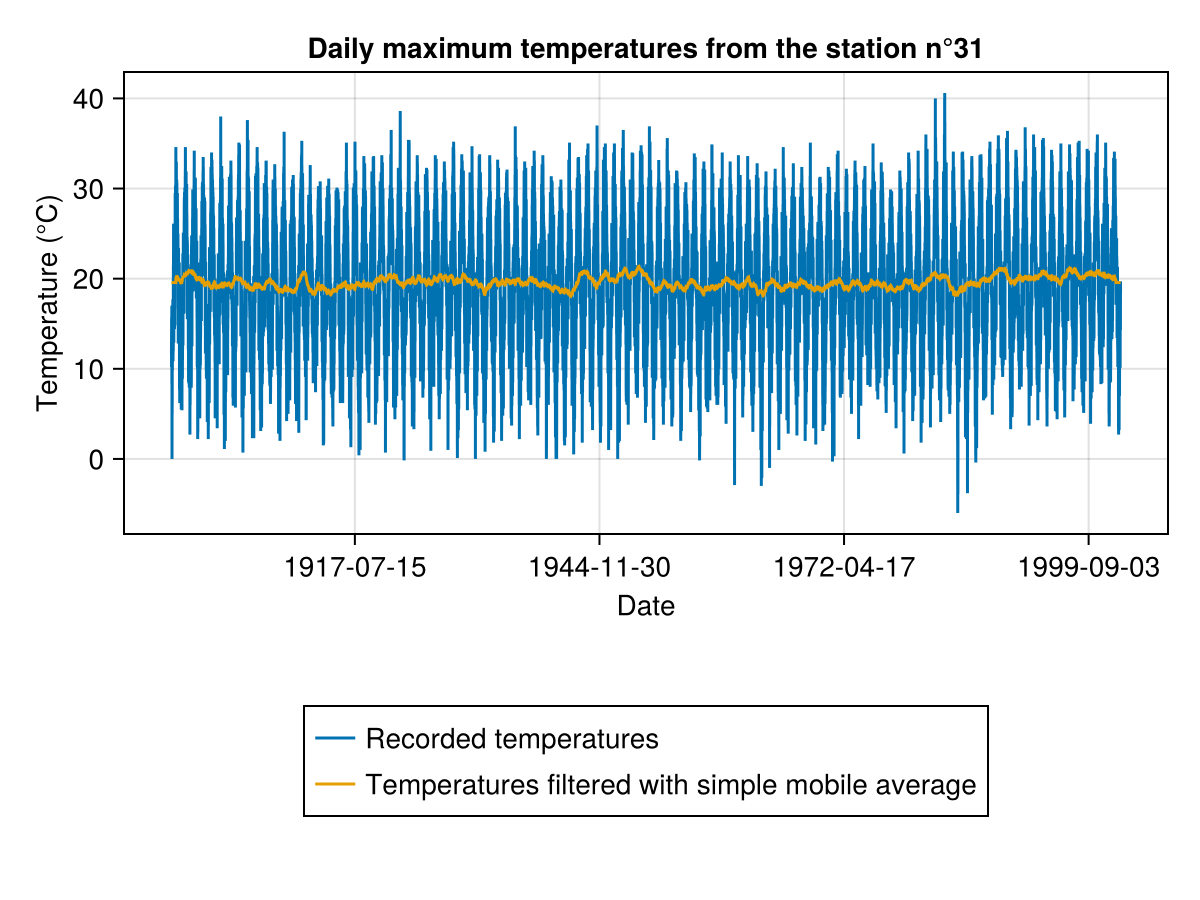

In [2]:
series,fig=extract_series("TX_STAID000031.txt",plot=true)
fig

## Drift

MSE estimators to estimate drift

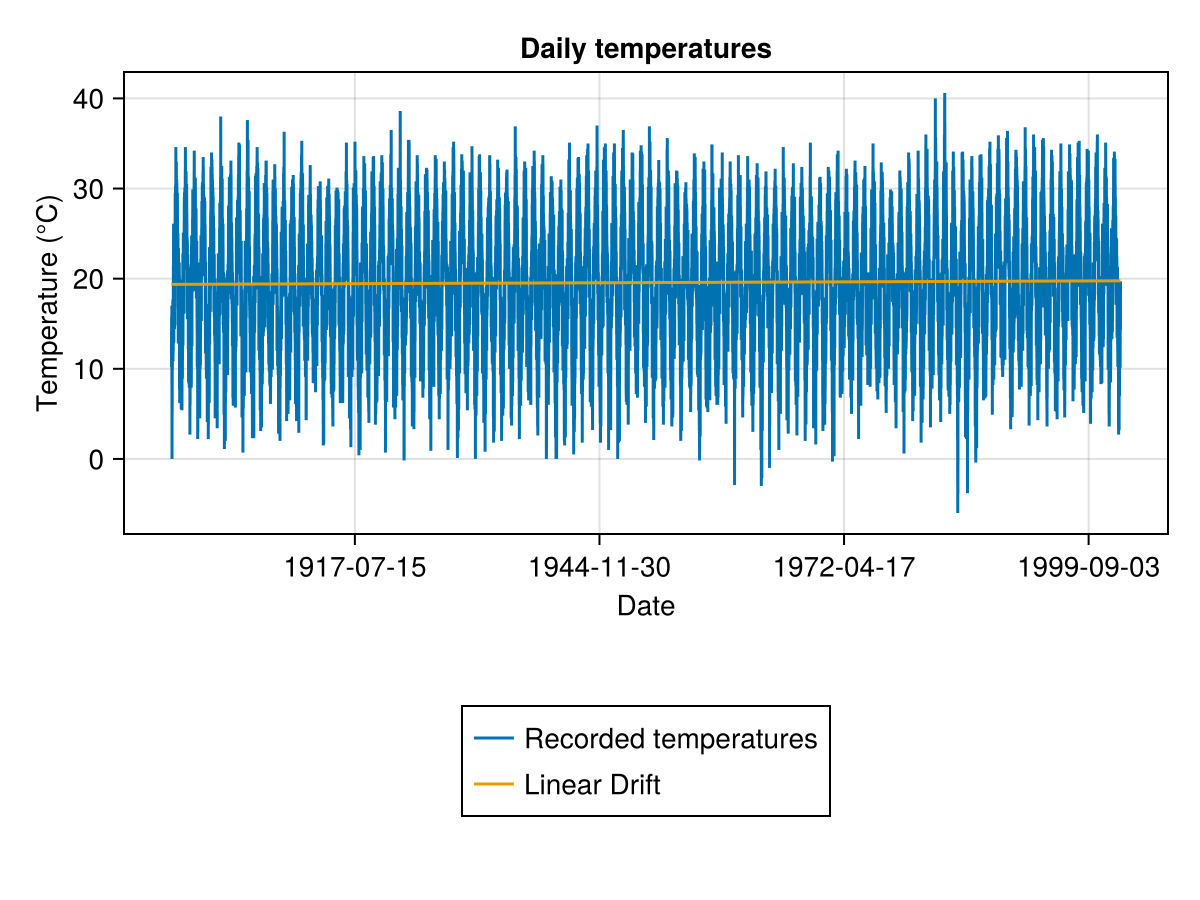

Intercept = 19.366009056392556
Slope = 1.0215034069842917e-5


In [3]:
N=size(series)[1]
X=cat(ones(N),1:N,dims=2)
beta=inv(transpose(X)*X)*transpose(X)*series[!,2]

fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE, series[!,2])
plot2=lines!(ax,series.DATE,X*beta)
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Linear Drift"])
display(fig)

println("Intercept = $(beta[1])")
println("Slope = $(beta[2])")

We can see that the drift is (almost) only a constant. We can consider it in our periodicity component estimation, as the $\mu$ parameter.

In [4]:
try 
    using RCall
catch ; 
    import Pkg
    Pkg.add("RCall")
    using RCall
end
R"""
z<-$(series[!,2])
t<-1:$N
model<-lm(z~t)
summary(model)
"""

RObject{VecSxp}

Call:
lm(formula = z ~ t)

Residuals:
     Min       1Q   Median       3Q      Max 
-25.6939  -5.3835  -0.3396   5.6837  20.9115 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.937e+01  6.916e-02 280.020  < 2e-16 ***
t           1.021e-05  3.091e-06   3.305  0.00095 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.808 on 38756 degrees of freedom
Multiple R-squared:  0.0002818,	Adjusted R-squared:  0.000256 
F-statistic: 10.92 on 1 and 38756 DF,  p-value: 0.0009499



In [5]:
# include("utils/Missing_values.jl")
# ImputeMissingValues!(series[!,2],series.DATE)
# N=length(series[!,2])

# 1.Trigonometrical parametrical model

In this model the periodicity $S_t$ will follow this equation :  $S_t = \mu + a\cos(\frac{2πt}{365.25}) + b\sin(\frac{2πt}{365.25})$. $\mu$, $a$ and $b$ will be estimated by fitting this equation on our series with an OLS regression.

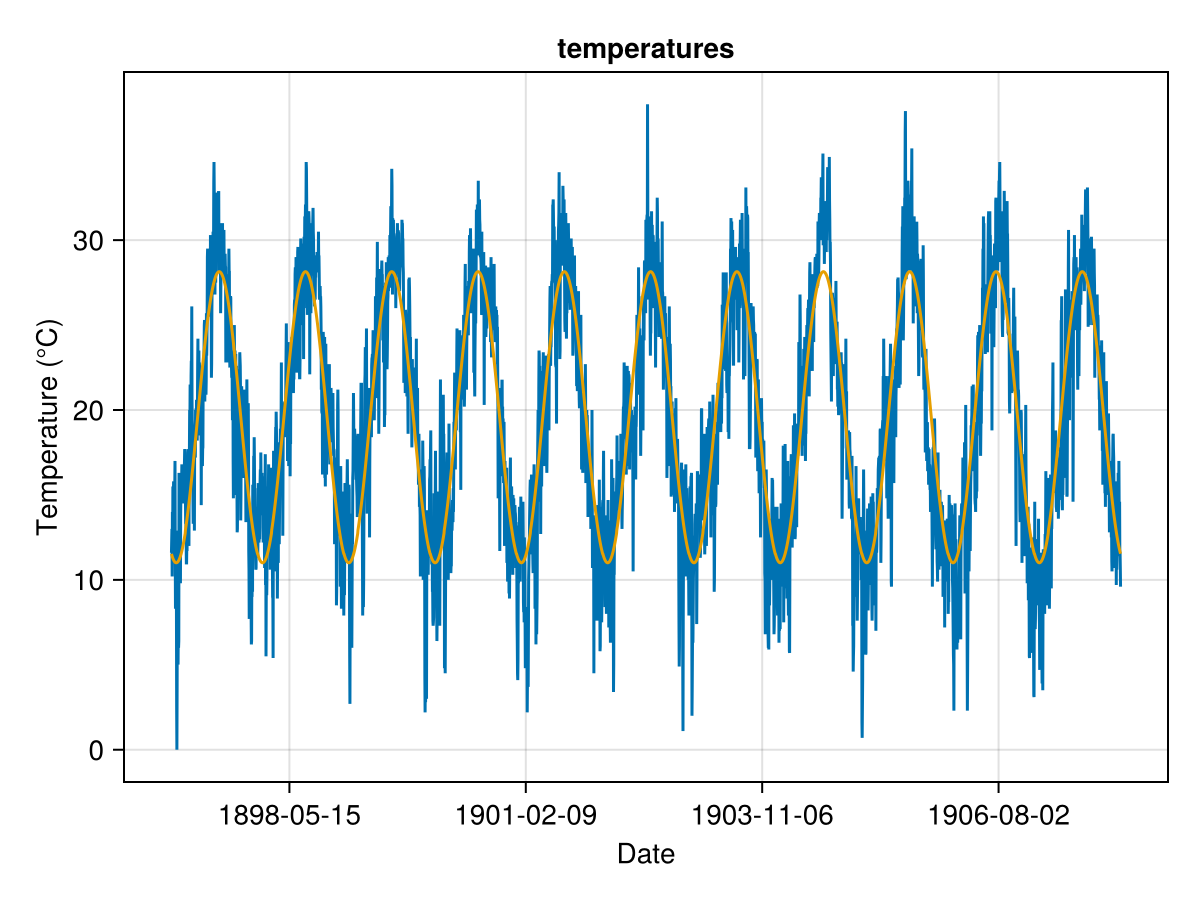

In [6]:
include("utils/periodicity.jl")
trigo_function=fitted_periodicity_fonc(series[!,2],series.DATE)
periodicity=trigo_function.(series.DATE)
period=trigo_function.(Date(0):Date(1)-Day(1))

Myyear=Iyear(series.DATE,year(series.DATE[1]):year(series.DATE[1]) + 10)
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

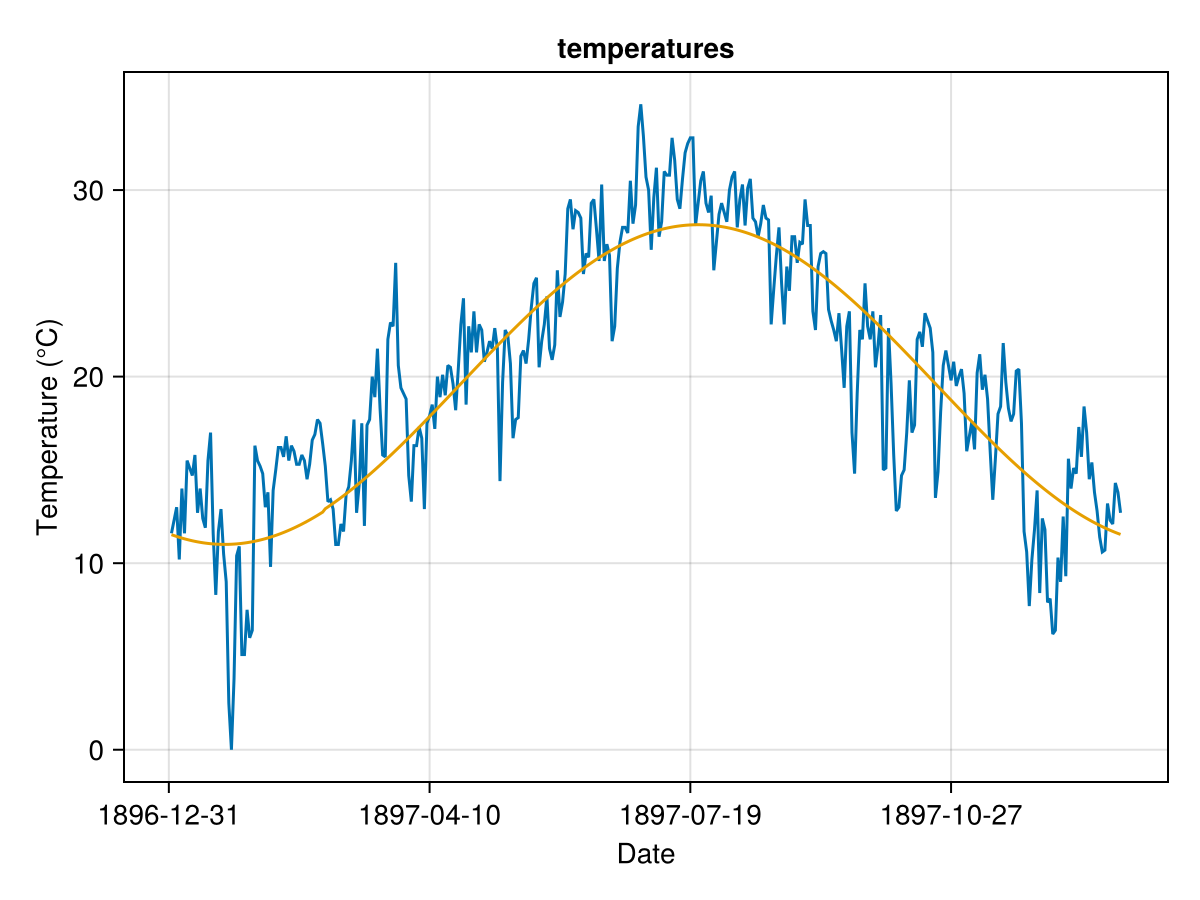

In [7]:
Myyear=Iyear(series.DATE,year(series.DATE[1]))
fig, ax = lines(series.DATE[Myyear],series[Myyear,2])
lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

We will work on the series without the periodicity : 

In [8]:
x=series[!,2]-periodicity

38758-element Vector{Float64}:
  0.07104304037398812
  0.8205179297211718
  1.5675970551600766
 -1.1877335153749673
  2.654512999148631
  0.29432409677359495
  4.231687996252475
  3.866593640534054
  3.499030700035446
  4.628989575698913
  ⋮
  3.115653785732892
  0.9864740732926229
 -0.5439076135917666
 -1.475452691233622
  0.39187776833445476
  3.1581230258407125
  3.52332266315587
  1.9875165715796825
  2.5507449400359867

In [9]:
include("utils/Estimation.jl")
Φ, σ=LL_AR_Estimation(x,1)

ERROR: LoadError: too many parameters for type AbstractInterpolation
Stacktrace:
 [1] top-level scope
   @ C:\Users\goninarn\.julia\packages\SparseConnectivityTracer\litqn\ext\SparseConnectivityTracerDataInterpolationsExt.jl:28
 [2] include
   @ .\Base.jl:557 [inlined]
 [3] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
   @ Base .\loading.jl:2881
 [4] top-level scope
   @ stdin:6
in expression starting at C:\Users\goninarn\.julia\packages\SparseConnectivityTracer\litqn\ext\SparseConnectivityTracerDataInterpolationsExt.jl:3
in expression starting at stdin:6
┌ Error: Error during loading of extension SparseConnectivityTracerDataInterpolationsExt of SparseConnectivityTracer, use `Base.retry_load_extensions()` to retry.
│   exception = 1-element ExceptionStack:
Failed to precompile SparseConnectivityTracerDataInterpolationsExt [

([0.7045954012280973], 2.1976783974775653)

## Autocorrelations

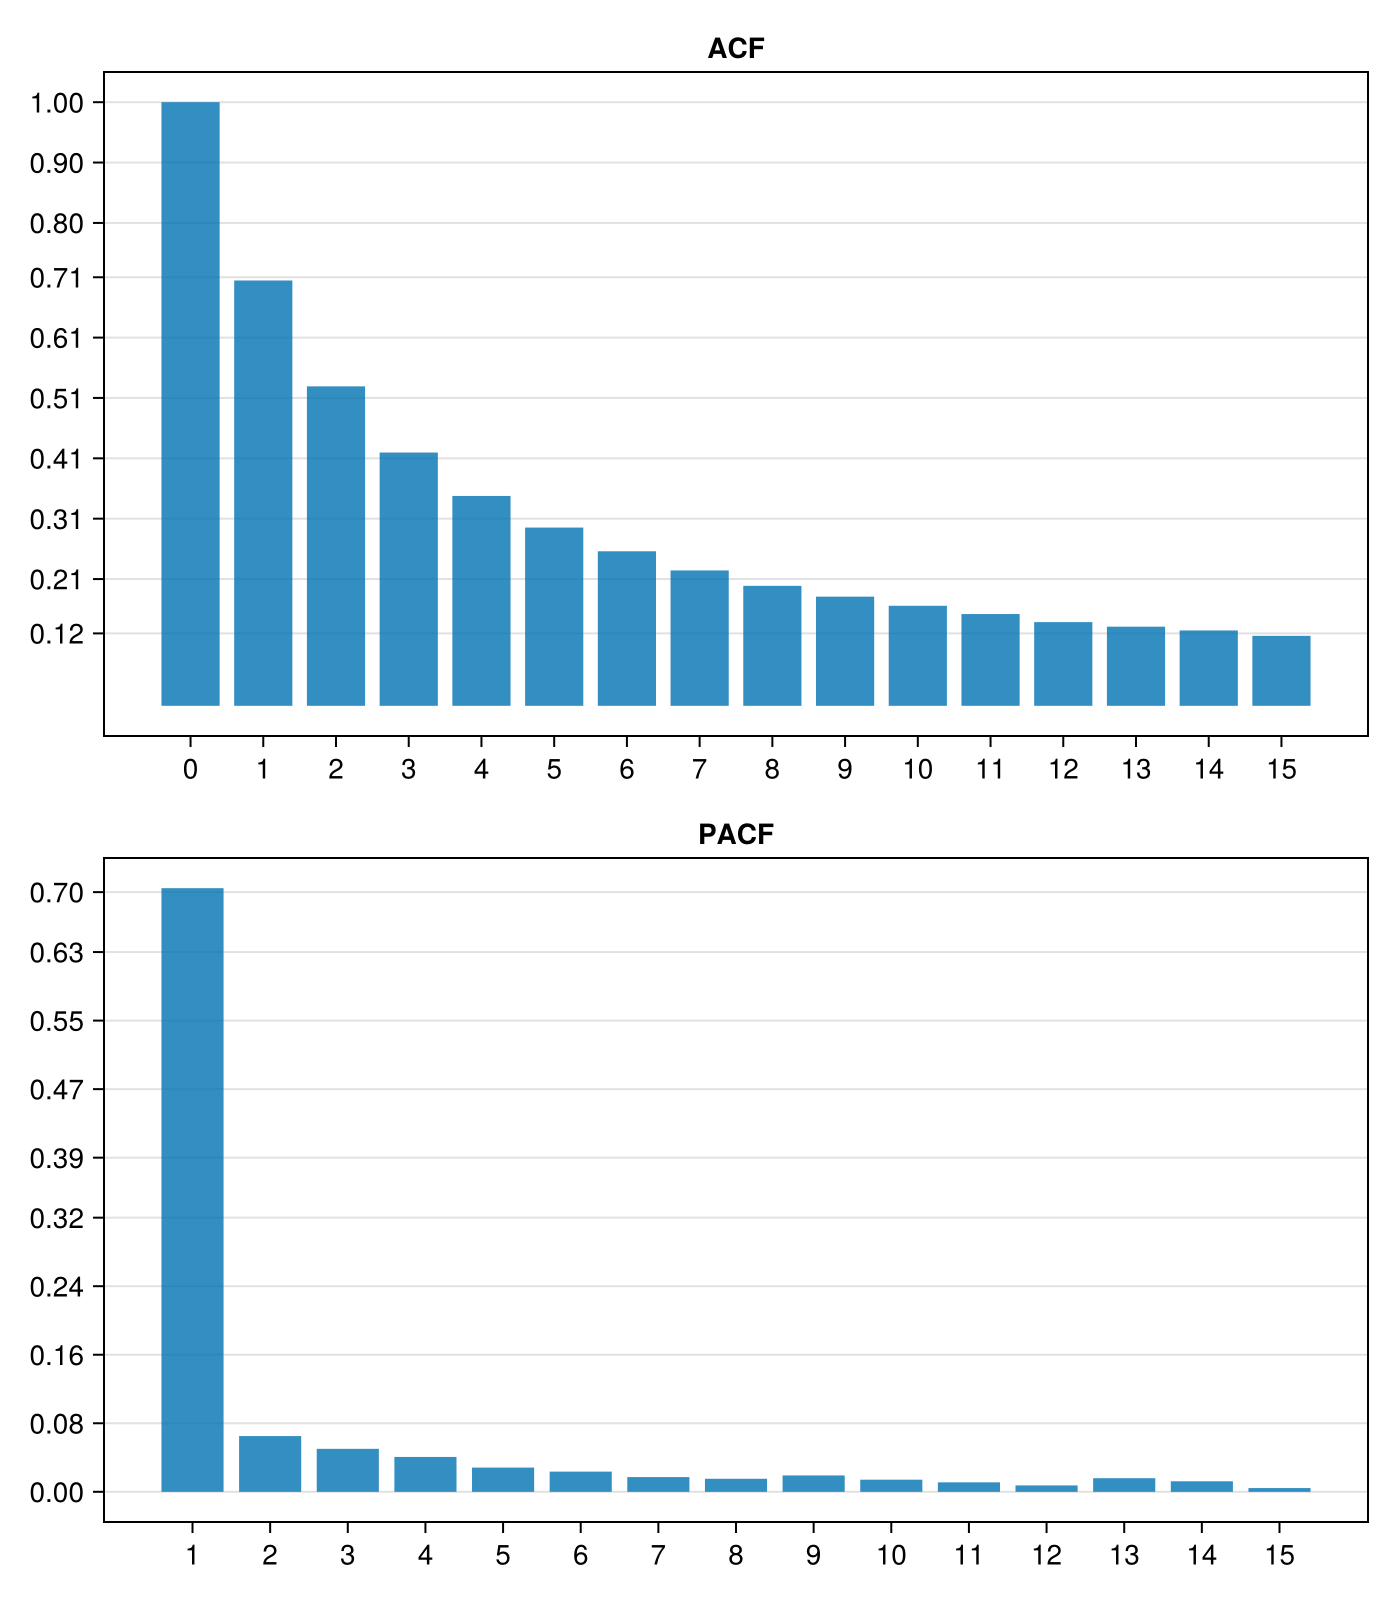

In [10]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

It still looks like an AR(1) model

## Estimation and simulation

In [11]:
include("utils/Estimation.jl")
include("utils/Simulation.jl")
include("utils/Plotting.jl")

PlotParameters

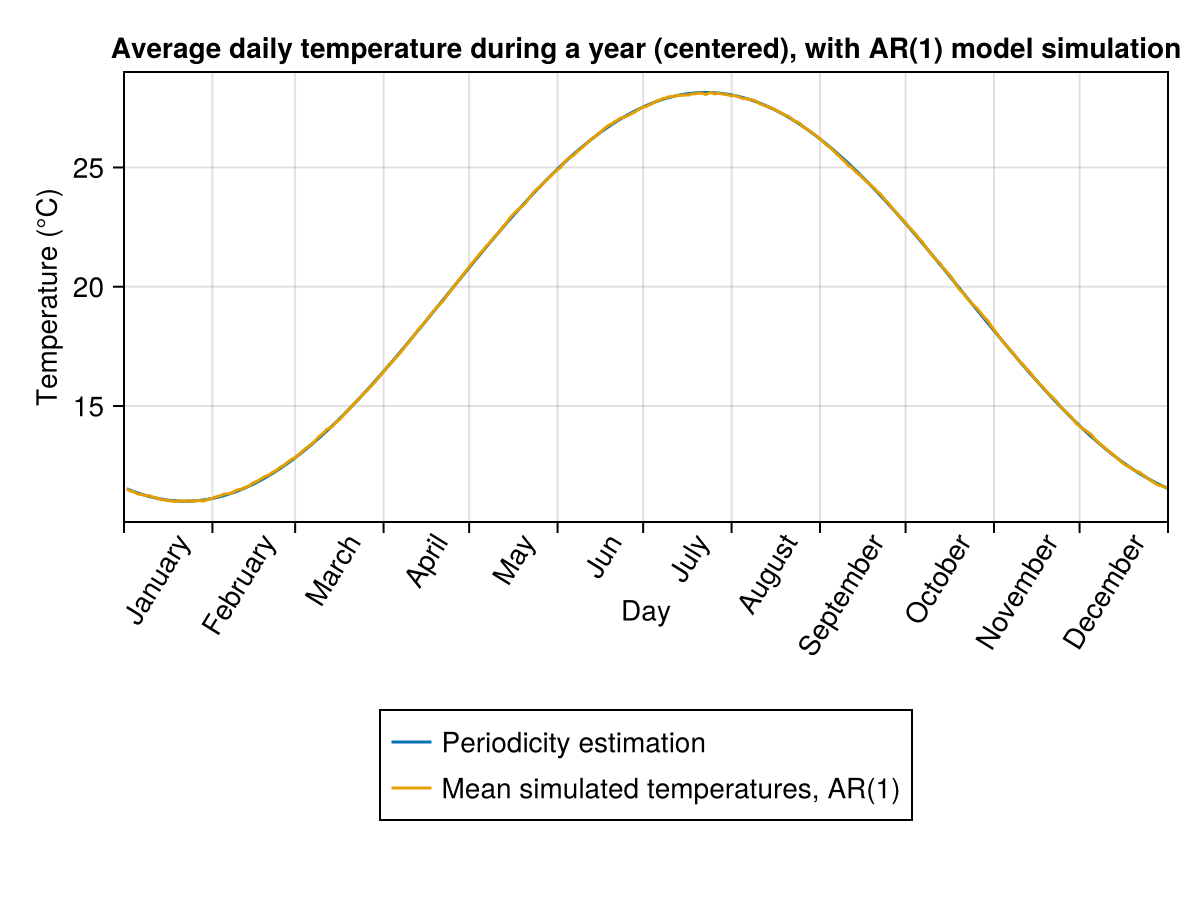

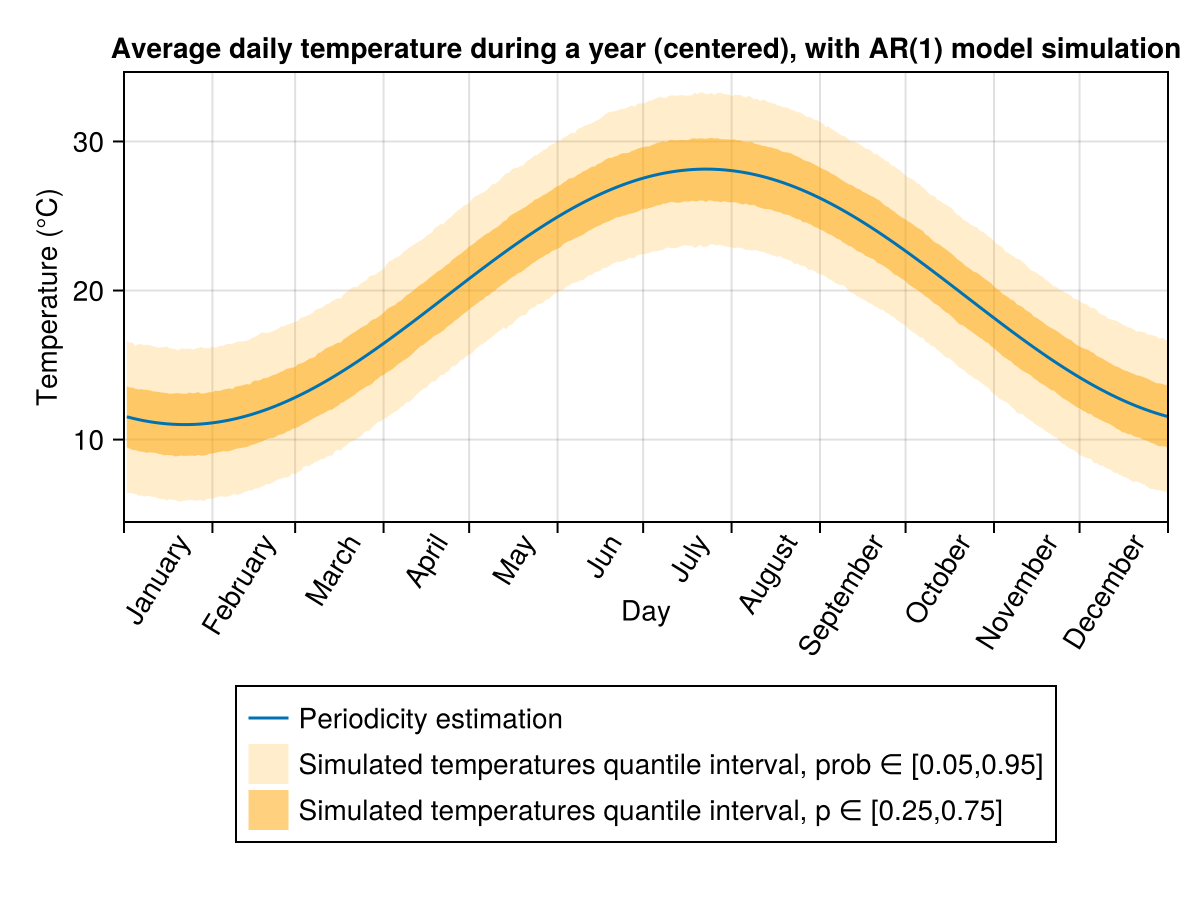

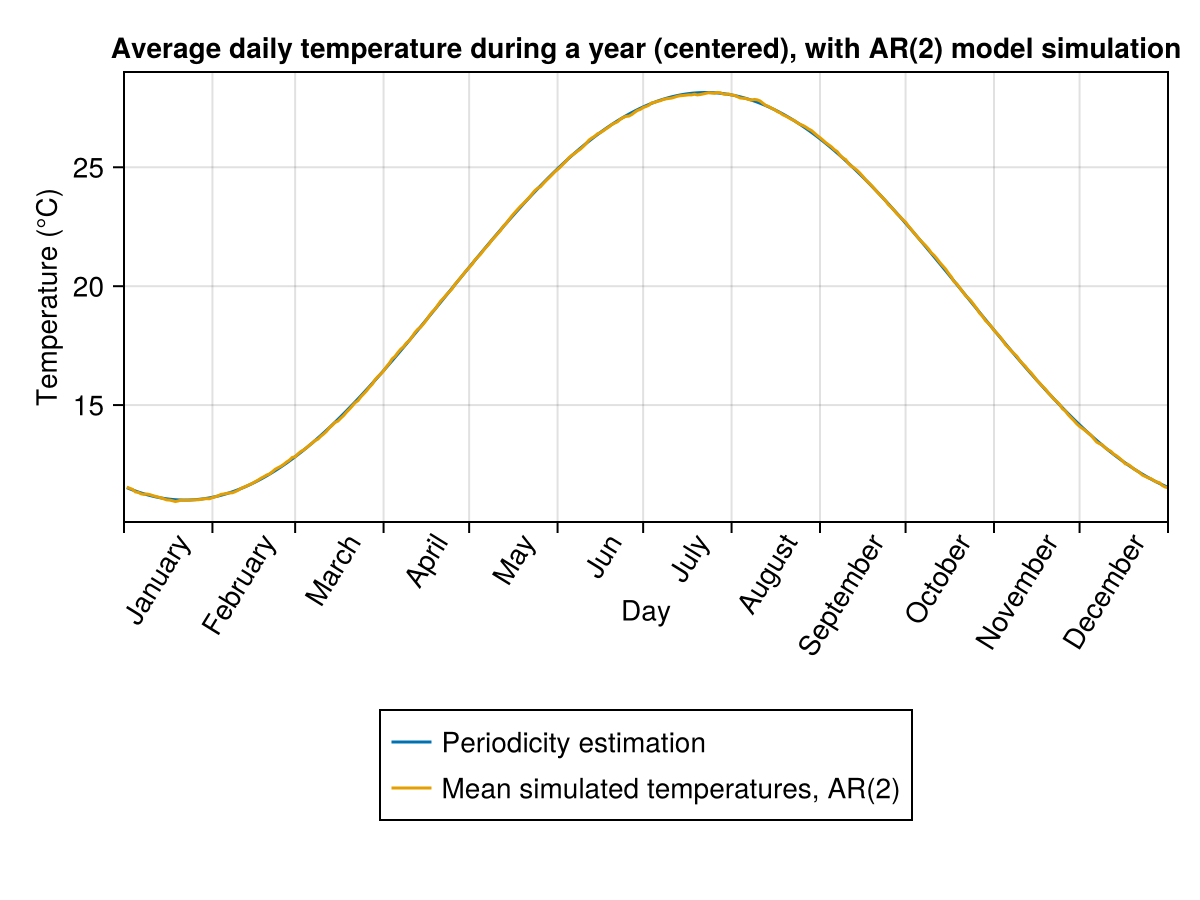

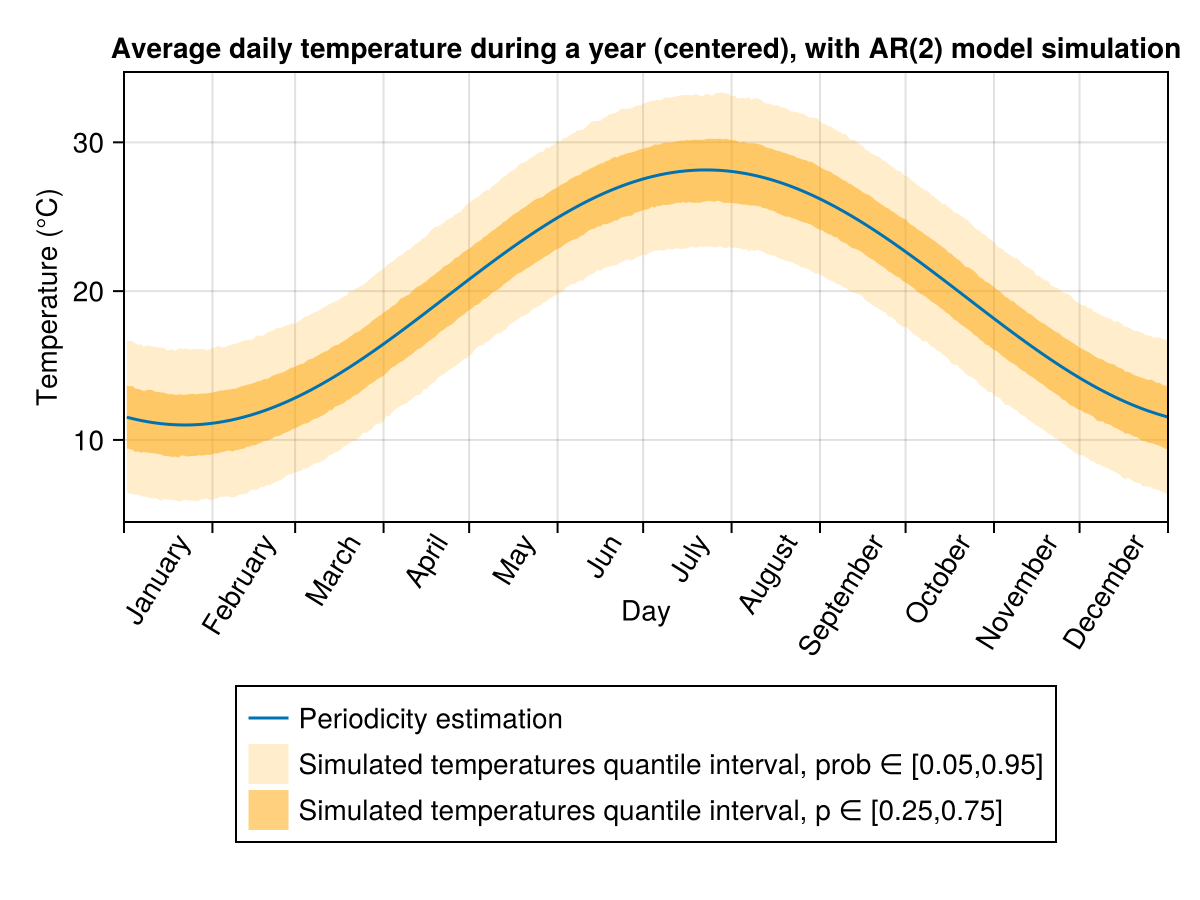

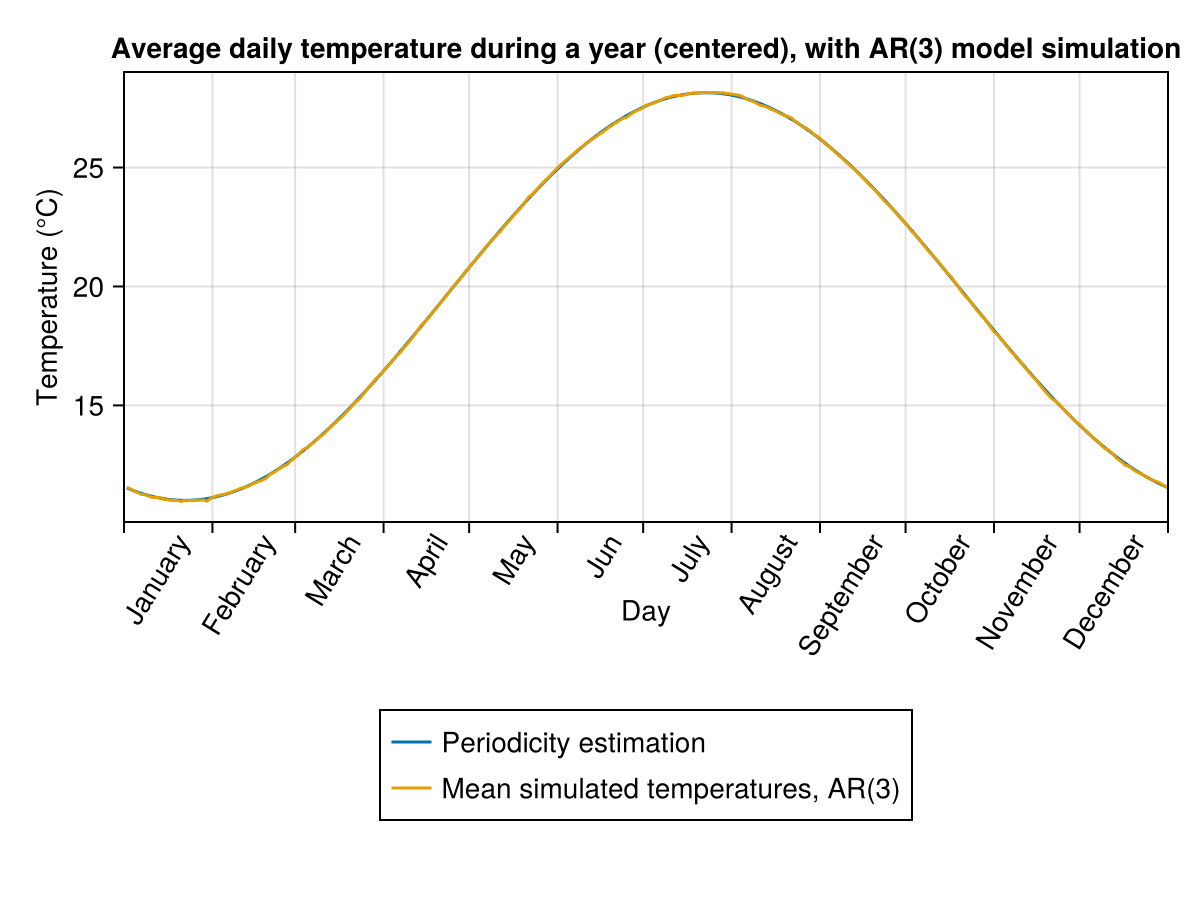

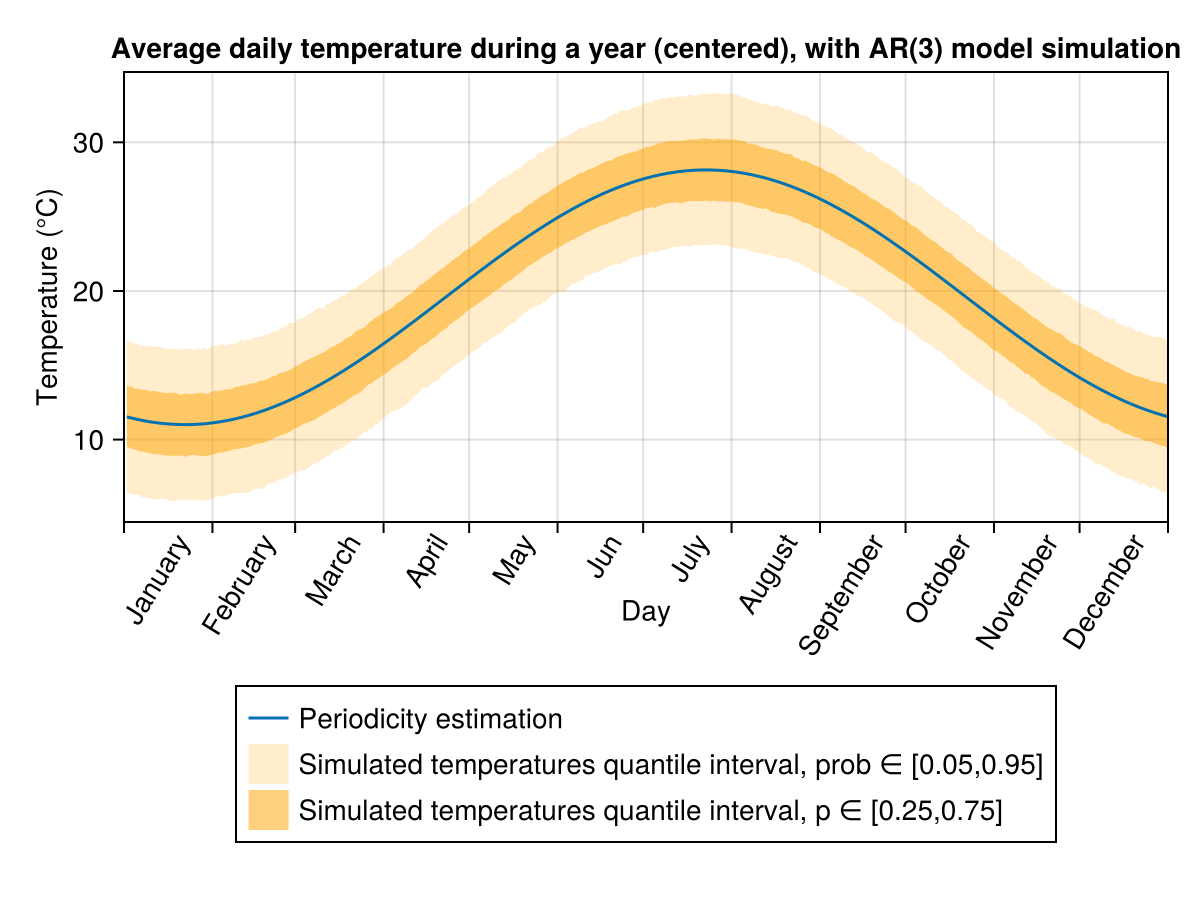

In [12]:
for p in 1:3
    Φ, σ=LL_AR_Estimation(x,p)
    sample_=GatherYearScenarios(SimulateScenarios(x[1:p], series.DATE[1]:series.DATE[end], Φ, σ, period; n=100), series.DATE[1]:series.DATE[end])
    display(PlotYearCurves([period,mean.(sample_)],["Periodicity estimation","Mean simulated temperatures, AR($(p))"],"Average daily temperature during a year (centered), with AR($(p)) model simulation"))
    display(PlotYearCurves(period,
    ["Periodicity estimation","Simulated temperatures quantile interval, prob ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
    "Average daily temperature during a year (centered), with AR($(p)) model simulation",
    [(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
    [("orange",0.2),("orange",0.5)]
    ))
end

# 2.Periodicity with regularization smoothing

In this model we use regularization smoothing on the average daily temperature to make our periodicity function. 
(see : https://docs.sciml.ai/DataInterpolations/stable/methods/)

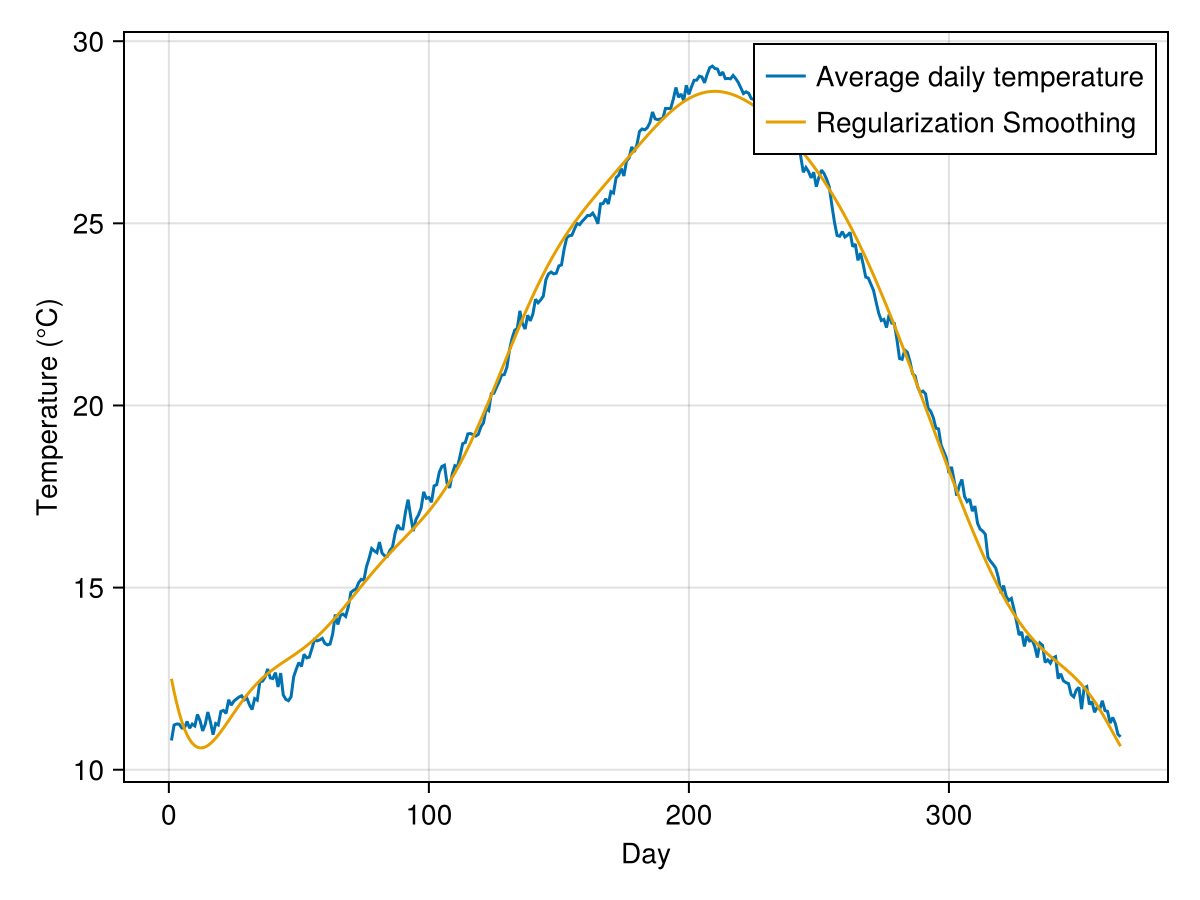

In [13]:
include("utils/Periodicity.jl")
Days_list=GatherYearScenario(series[!,2],series.DATE)

f=RegularizationSmooth(mean.(Days_list), 1:366, 9)
period=f.(dayofyear_Leap.(Date(0):Date(1)-Day(1)))
fig=Figure()
ax ,plt1= lines(fig[1:2,1:2],mean.(Days_list))
plt2=lines!(ax,f(1:366))
ax.xlabel="Day"
ax.ylabel="Temperature (°C)"
axislegend(ax,[plt1,plt2],["Average daily temperature","Regularization Smoothing"])
current_figure()

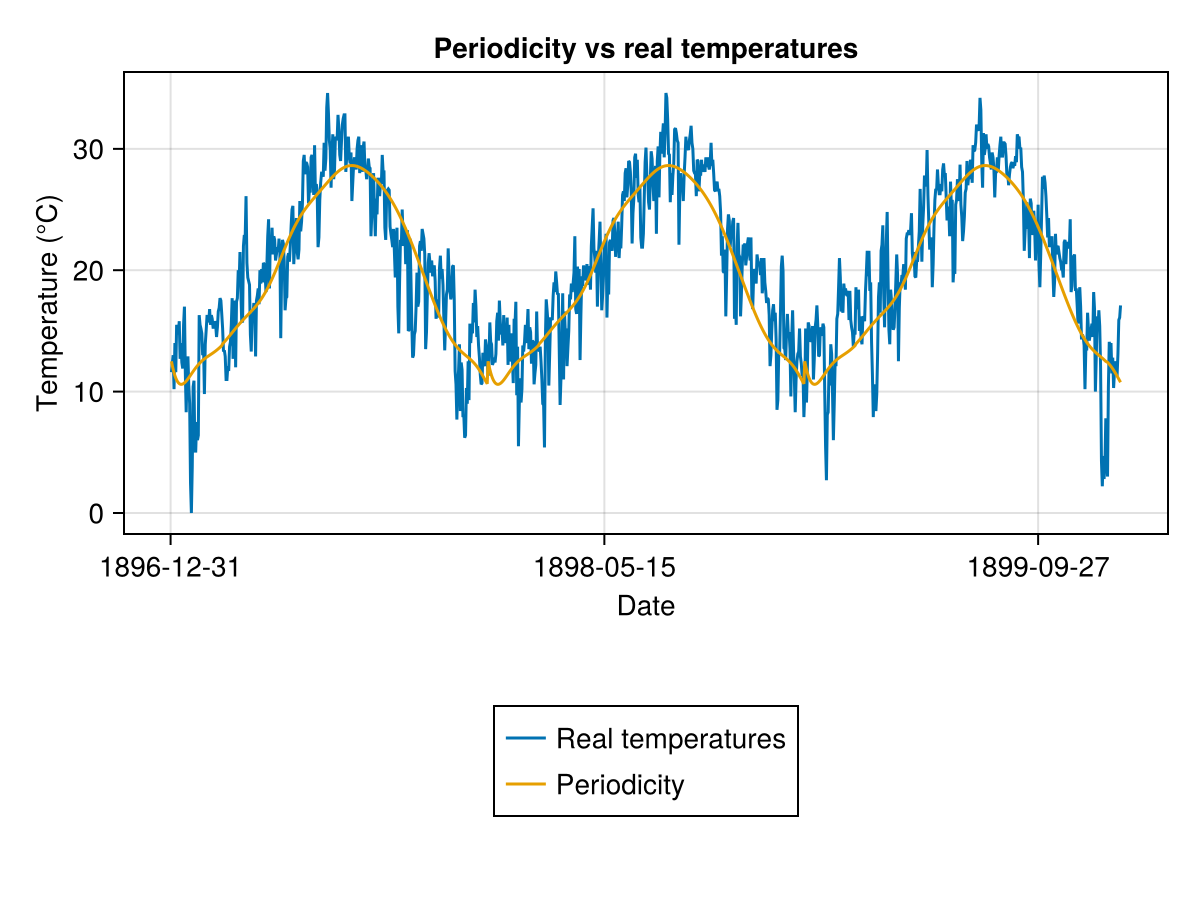

In [14]:
Smoothed_function(i)=f(dayofyear_Leap(i,series.DATE[1]))
periodicity=Smoothed_function.(1:N)

fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[1]):year(series.DATE[1]) + 2)
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
current_figure()

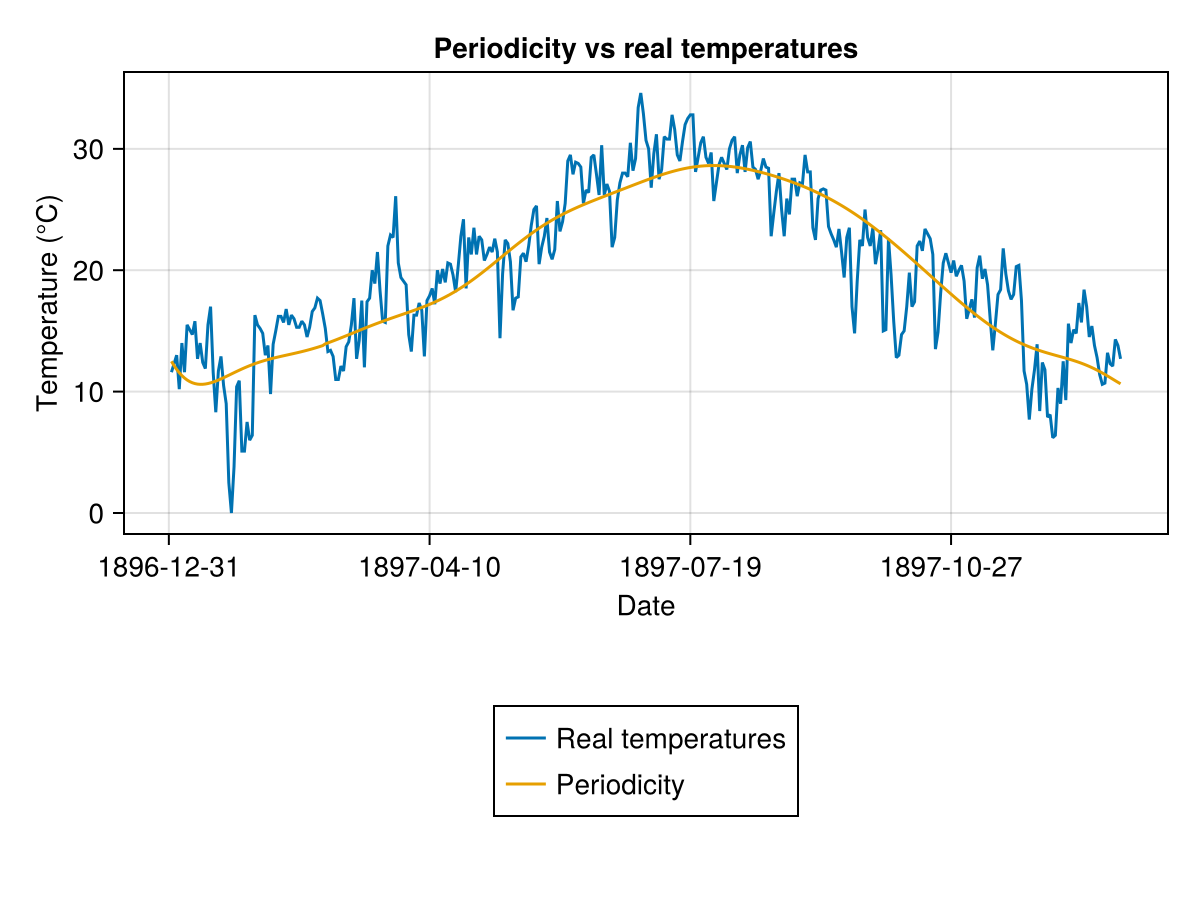

1897-01-01
1897-12-31


CairoMakie.Screen{IMAGE}


In [15]:
fig=Figure()
Myyear=Iyear(series.DATE,year(series.DATE[1]))
ax ,plt1= lines(fig[1:2,1:2],series.DATE[Myyear],series[Myyear,2])
plt2=lines!(ax,series.DATE[Myyear],periodicity[Myyear])
ax.title="Periodicity vs real temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3,1:2],[plt1,plt2],["Real temperatures","Periodicity"])
println(series.DATE[Myyear][1])
println(series.DATE[Myyear][end])
display(fig)

## Estimation and simulation

In [16]:
include("utils/Estimation.jl")
include("utils/Simulation.jl")
include("utils/Plotting.jl")

PlotParameters

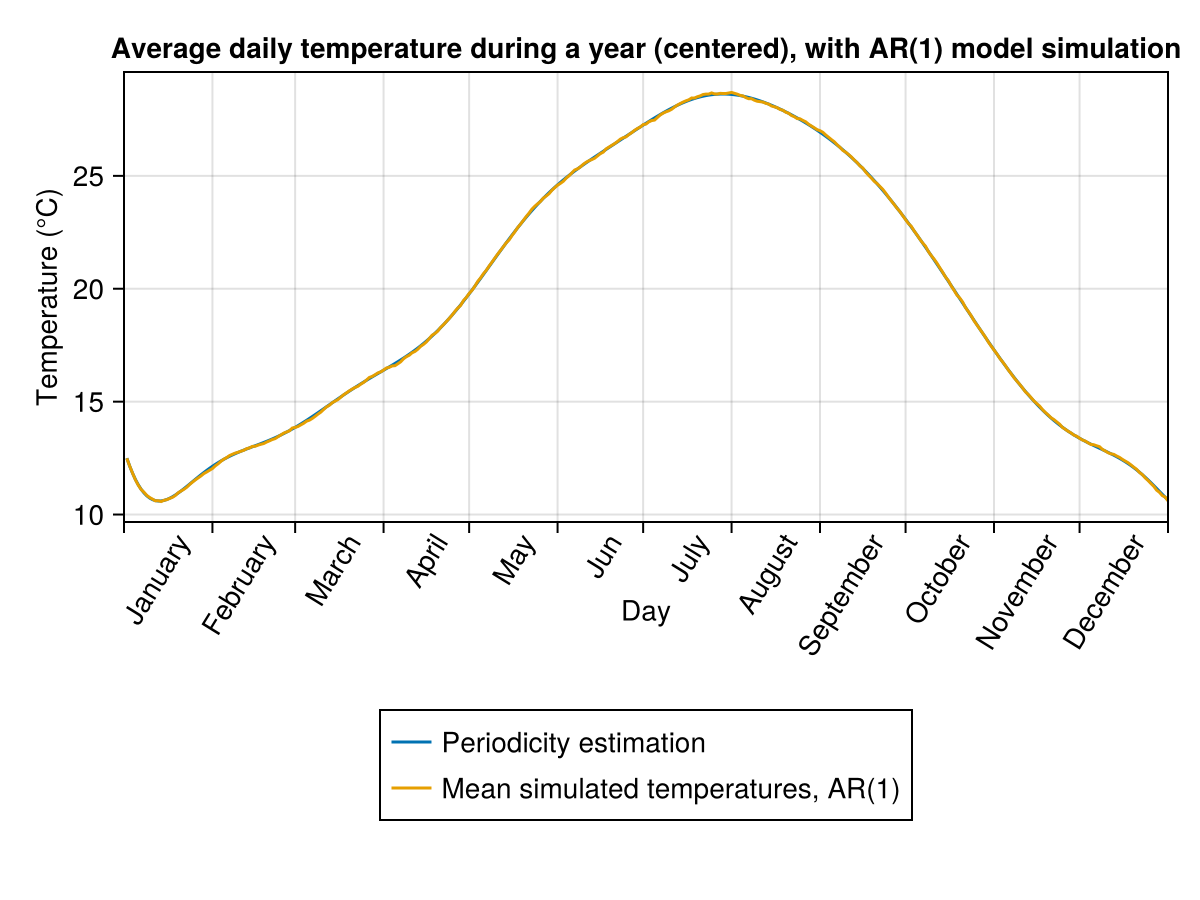

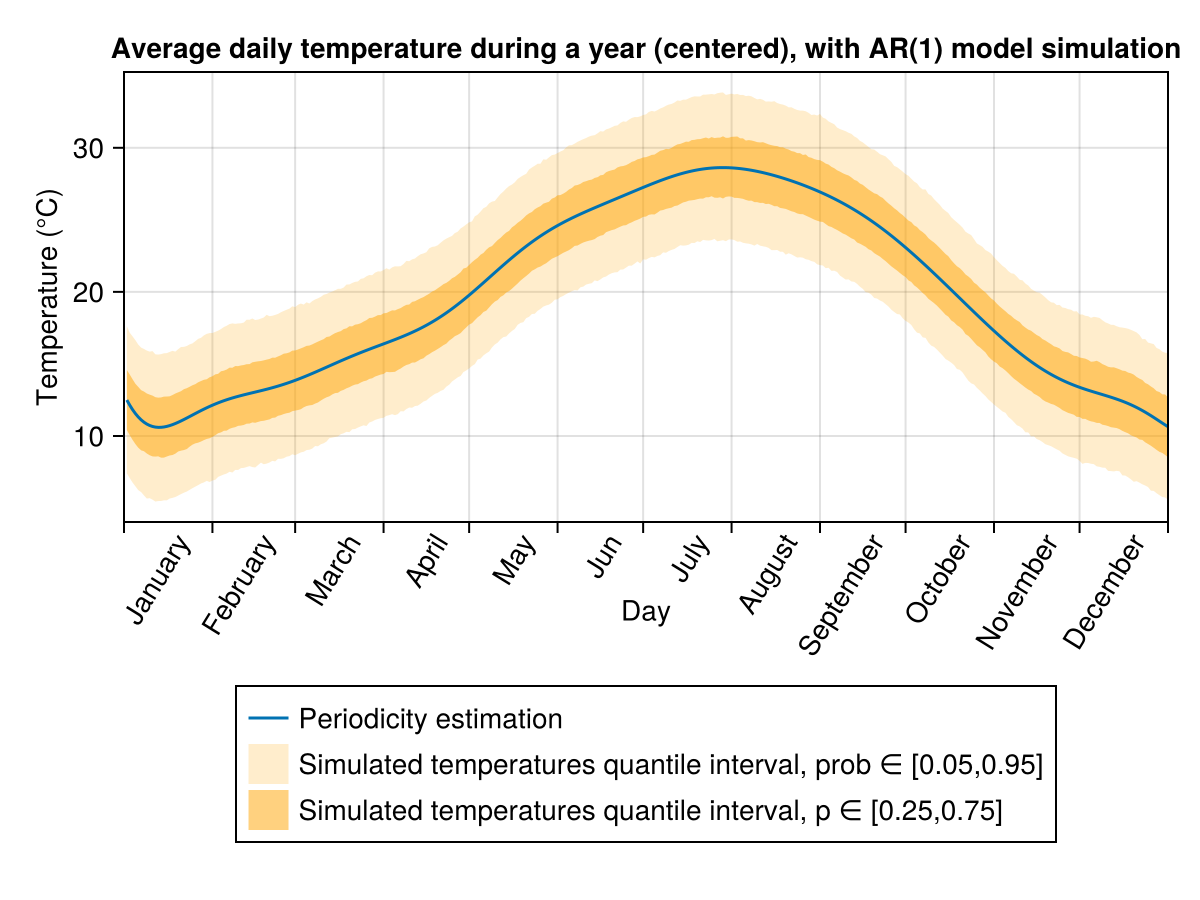

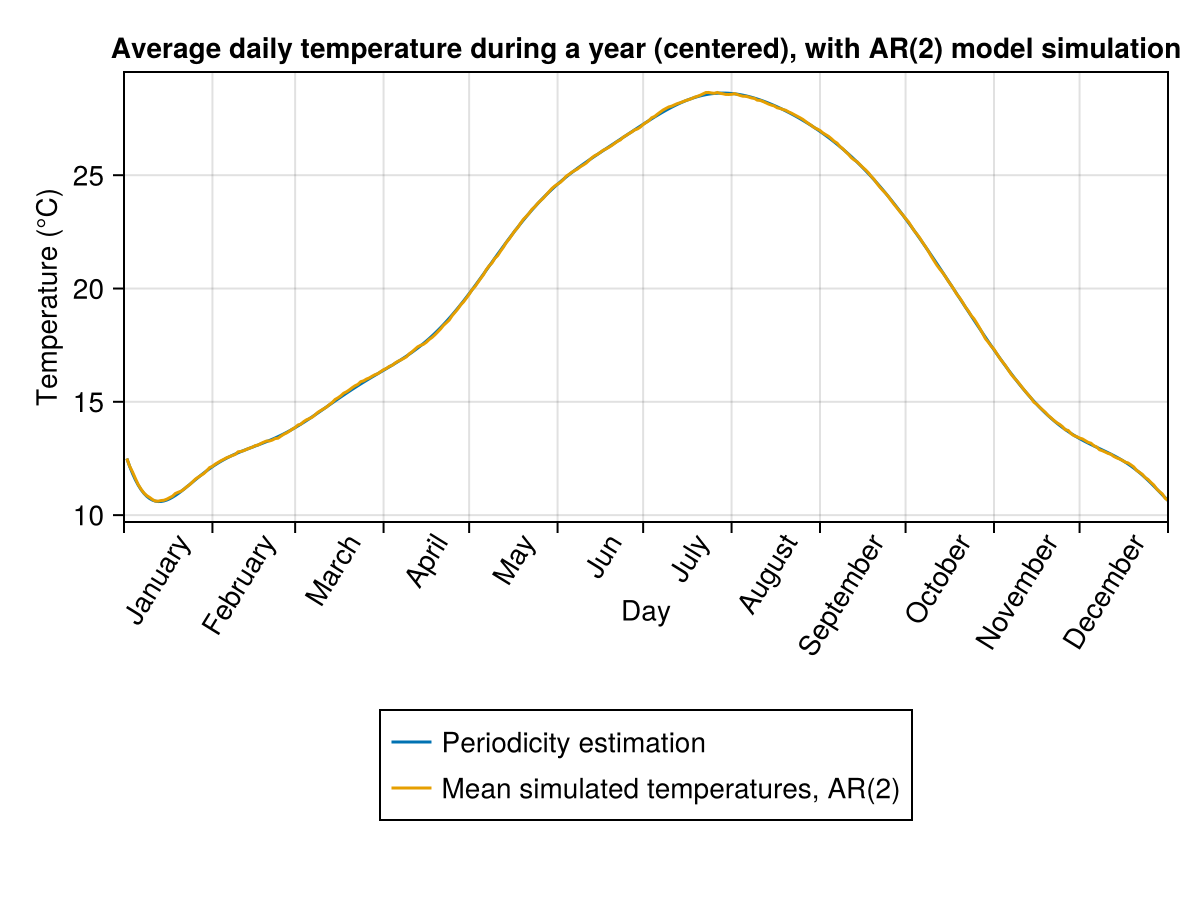

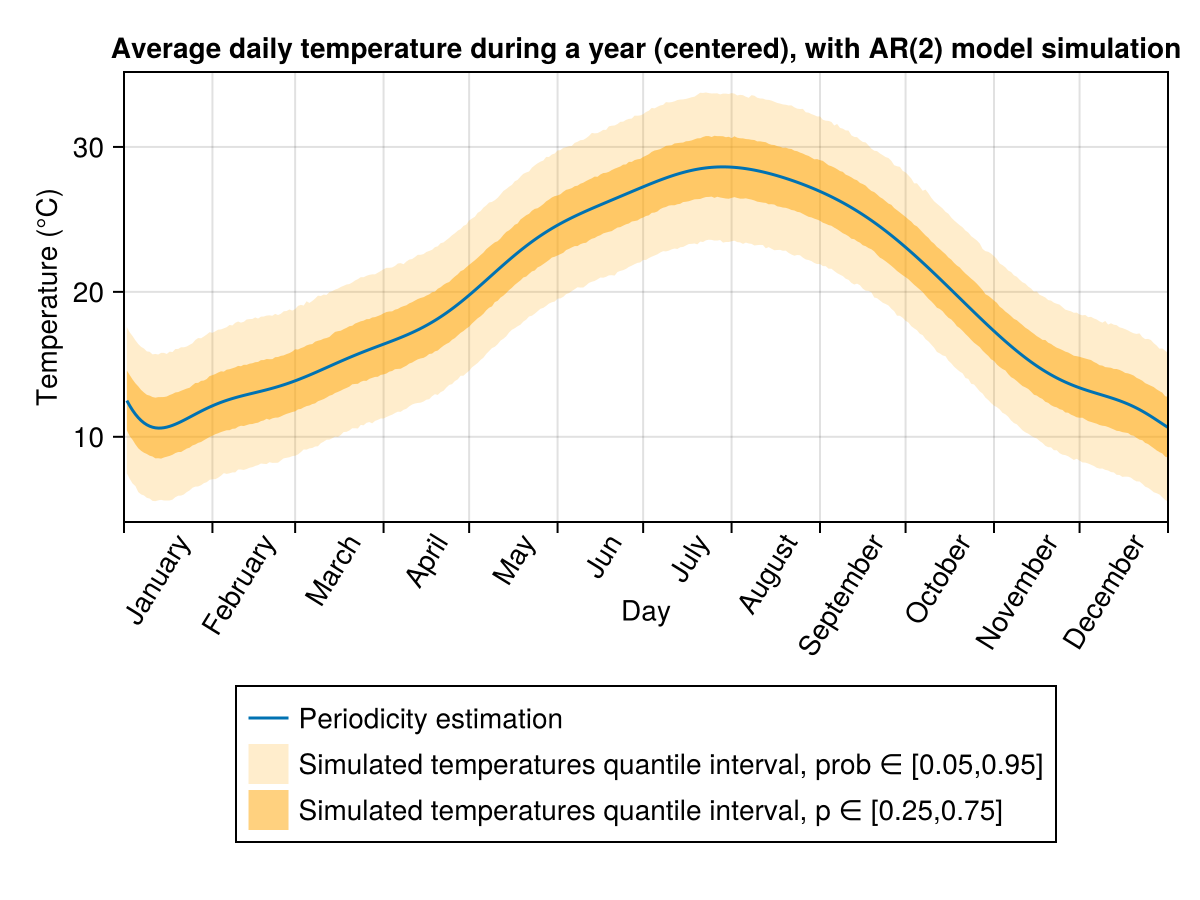

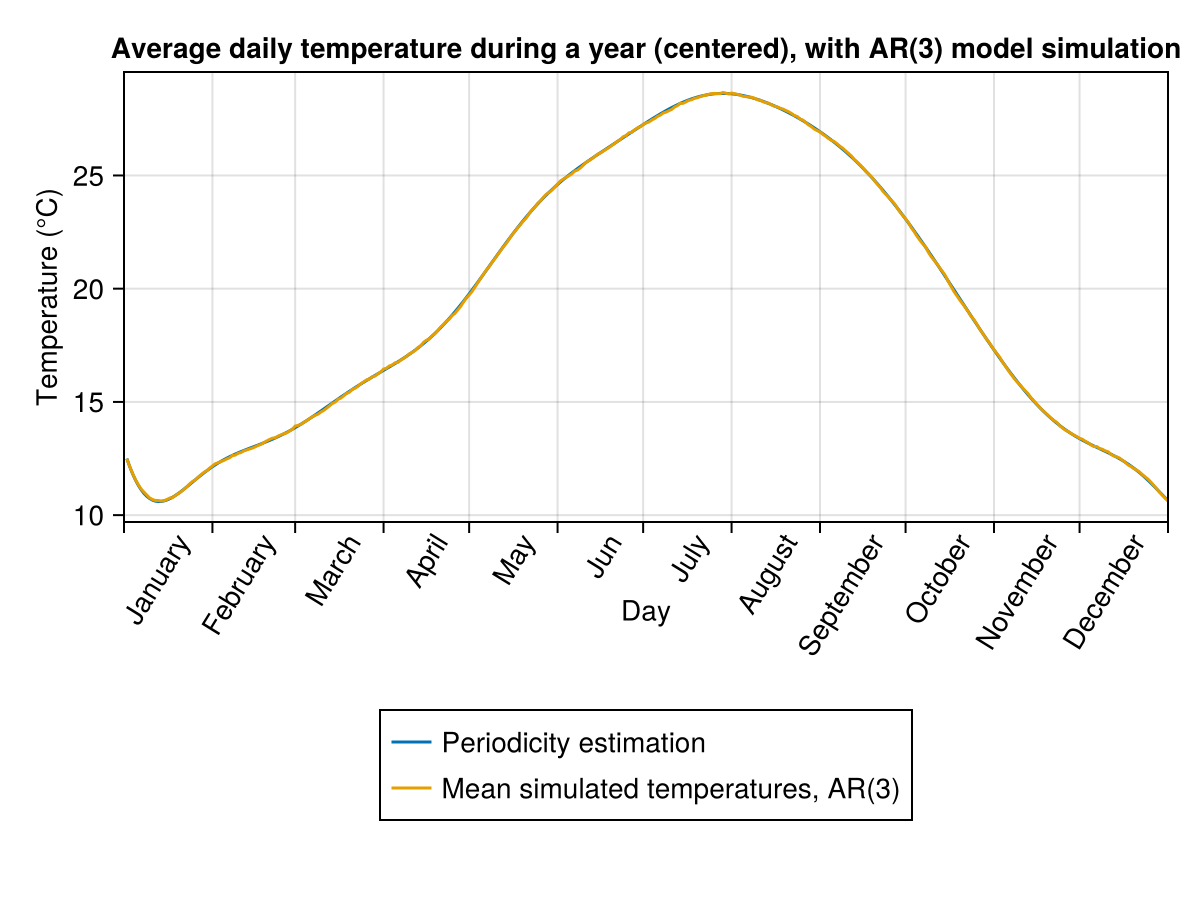

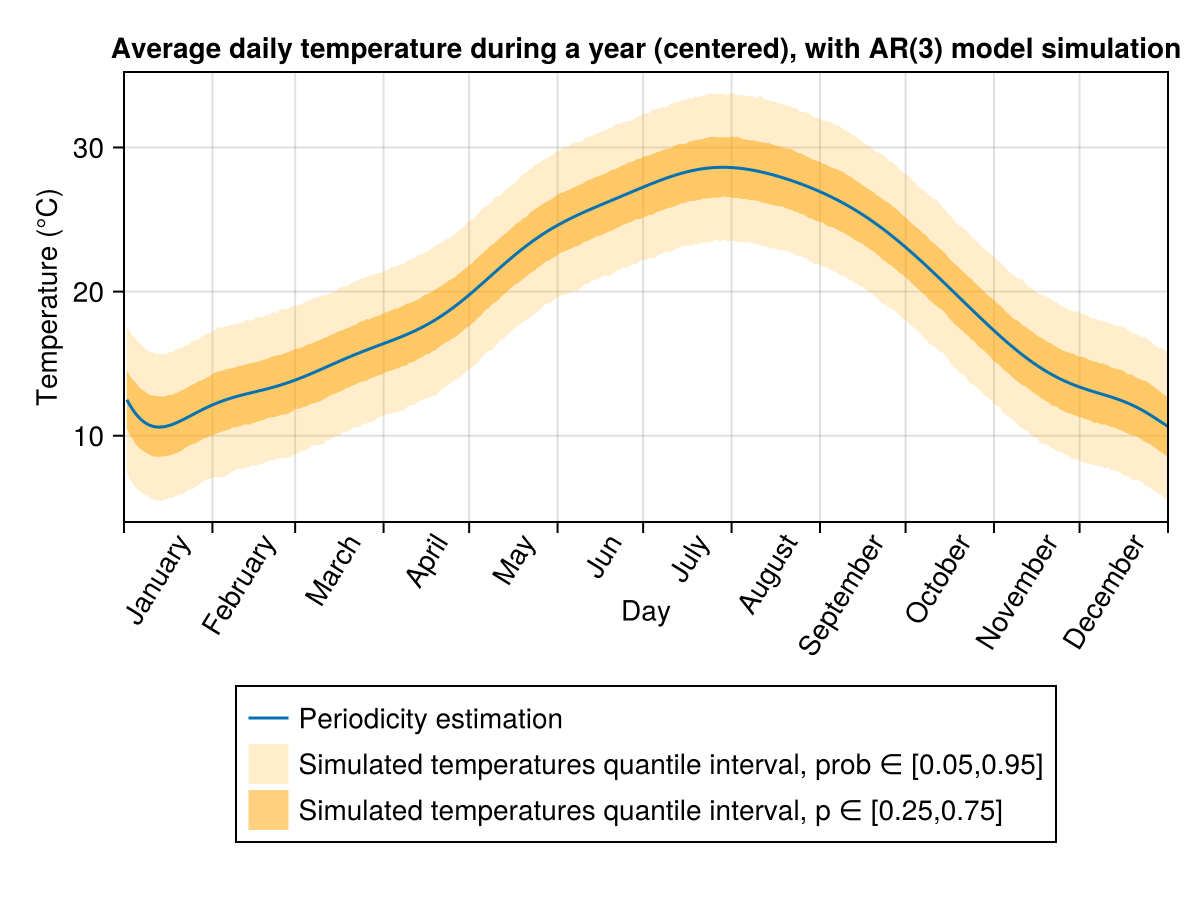

In [17]:
for p in 1:3
    Φ, σ=LL_AR_Estimation(x,p)
    sample_=GatherYearScenarios(SimulateScenarios(x[1:p], series.DATE[1]:series.DATE[end], Φ, σ, period; n=100), series.DATE[1]:series.DATE[end])
    display(PlotYearCurves([period,mean.(sample_)],["Periodicity estimation","Mean simulated temperatures, AR($(p))"],"Average daily temperature during a year (centered), with AR($(p)) model simulation"))
    display(PlotYearCurves(period,
    ["Periodicity estimation","Simulated temperatures quantile interval, prob ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
    "Average daily temperature during a year (centered), with AR($(p)) model simulation",
    [(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
    [("orange",0.2),("orange",0.5)]
    ))
end